In [1]:
import io
import tarfile
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import linregress

from ugradiolab import Record
from ugradiolab.analysis import Spectrum

# Physical constants
k_B   = 1.380649e-23  # Boltzmann constant (J/K)
T_HOT = 310.0         # Human body temperature (K)
T_COLD = 20.0         # Assumed sky temperature at horizontal pointing (K)
                      # CMB ~2.73 K + Galactic + atmosphere; adjust as needed

HI_FREQ = 1420.405751768  # 21-cm hydrogen line (MHz)

# Data sources
HOT_SRC  = 'labs/02/data/lab2_hot_cal.tar.gz'
COLD_SRC = 'labs/02/data/lab2_cold_cal.tar.gz'

/home/ikaros/projects/ay-121/.venv/lib/python3.12/site-packages/rtlsdr/__init__.py:19: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


In [ ]:
def _resolve_source(source):
    src = Path(source).expanduser()
    if src.exists():
        return src
    cwd = Path.cwd().resolve()
    for base in (cwd, *cwd.parents):
        candidate = (base / source).resolve()
        if candidate.exists():
            return candidate
    raise FileNotFoundError(f'Could not find {source!r}')


def _prefix_from_name(name):
    return Path(name).name.rsplit('_', 3)[0]


def load_dataset(source):
    src = _resolve_source(source)
    data = {}
    if src.is_dir():
        for f in sorted(src.glob('*.npz')):
            data[_prefix_from_name(f.name)] = Record.load(f)
    elif src.is_file() and src.suffixes[-2:] == ['.tar', '.gz']:
        # Iterate sequentially — gzip streams don't support backward seeks,
        # so getmembers() + random extractfile() can silently produce empty reads.
        with tarfile.open(src, 'r:gz') as tar:
            for m in tar:
                if not (m.isfile() and m.name.endswith('.npz')):
                    continue
                f = tar.extractfile(m)
                if f is None:
                    continue
                data[_prefix_from_name(m.name)] = Record.load(io.BytesIO(f.read()))
    if not data:
        raise RuntimeError(f'No .npz files found in {src}')
    return data, src


hot_data,  hot_src  = load_dataset(HOT_SRC)
cold_data, cold_src = load_dataset(COLD_SRC)

# Pre-compute spectra for all records
hot_specs  = {k: Spectrum.from_record(v) for k, v in hot_data.items()}
cold_specs = {k: Spectrum.from_record(v) for k, v in cold_data.items()}

print(f'Hot cal:  {len(hot_data)} files from {hot_src}')
for key in sorted(hot_data):
    print(f'  {key}')
print()
print(f'Cold cal: {len(cold_data)} files from {cold_src}')
for key in sorted(cold_data):
    rec = cold_data[key]
    print(f'  {key:20s} ({"cal" if rec.uses_synth else "obs"})')

In [3]:
# Spectra are pre-computed in hot_specs / cold_specs (see load cell).
spec0 = hot_specs['HOT-BASE-PRE']
print(f'Frequency range: {spec0.freqs_mhz[0]:.3f} – {spec0.freqs_mhz[-1]:.3f} MHz')
print(f'Frequency bins:  {len(spec0.freqs_mhz)}')

Frequency range: 1418.720 – 1421.280 MHz
Frequency bins:  32768


In [4]:
spec_pre  = hot_specs['HOT-BASE-PRE']
spec_post = hot_specs['HOT-BASE-POST']
psd_cold  = (spec_pre.psd + spec_post.psd) / 2.0
freqs     = spec_pre.freqs_mhz

hot_keys = sorted(k for k in hot_data if k.startswith('HOT-LOAD-'))
psd_hot  = np.mean([hot_specs[k].psd for k in hot_keys], axis=0)

print(f'Cold load: HOT-BASE-PRE + HOT-BASE-POST (averaged)')
print(f'Hot load:  {len(hot_keys)} captures ({hot_keys[0]} … {hot_keys[-1]})')
print(f'Frequency range: {freqs[0]:.3f} – {freqs[-1]:.3f} MHz  ({len(freqs)} bins)')
print()
print(f'Mean PSD  cold: {np.mean(psd_cold):.3e} counts²')
print(f'Mean PSD  hot:  {np.mean(psd_hot):.3e} counts²')
print(f'Ratio (total):  {np.sum(psd_hot) / np.sum(psd_cold):.4f}')

Cold load: HOT-BASE-PRE + HOT-BASE-POST (averaged)
Hot load:  10 captures (HOT-LOAD-01 … HOT-LOAD-10)
Frequency range: 1418.720 – 1421.280 MHz  (32768 bins)

Mean PSD  cold: 4.424e+04 counts²
Mean PSD  hot:  4.423e+04 counts²
Ratio (total):  0.9997


In [5]:
P_cold_samples = np.array([
    hot_specs[k].total_power for k in ['HOT-BASE-PRE', 'HOT-BASE-POST']
])
P_hot_samples = np.array([
    hot_specs[k].total_power for k in hot_keys
])

P_cold_mean, P_cold_std = P_cold_samples.mean(), P_cold_samples.std()
P_hot_mean,  P_hot_std  = P_hot_samples.mean(),  P_hot_samples.std()

Y     = P_hot_mean / P_cold_mean
Y_err = Y * np.sqrt((P_hot_std / P_hot_mean)**2 + (P_cold_std / P_cold_mean)**2)

T_sys     = (T_HOT - Y * T_COLD) / (Y - 1)
T_sys_err = abs((T_HOT - T_COLD) / (Y - 1)**2) * Y_err

print(f'Total power (cold): {P_cold_mean:.4e} ± {P_cold_std:.2e} counts²')
print(f'Total power (hot):  {P_hot_mean:.4e} ± {P_hot_std:.2e} counts²')
print()
print(f'Y-factor:  {Y:.4f} ± {Y_err:.4f}')
print()
print(f'T_hot  = {T_HOT:.1f} K  (assumed: human body)')
print(f'T_cold = {T_COLD:.1f} K  (assumed: sky at horizontal)')
print()
print(f'T_sys  = {T_sys:.1f} ± {T_sys_err:.1f} K')

Total power (cold): 1.4498e+09 ± 1.14e+06 counts²
Total power (hot):  1.4494e+09 ± 1.22e+06 counts²

Y-factor:  0.9997 ± 0.0012

T_hot  = 310.0 K  (assumed: human body)
T_cold = 20.0 K  (assumed: sky at horizontal)

T_sys  = -979482.8 ± 3808698.1 K


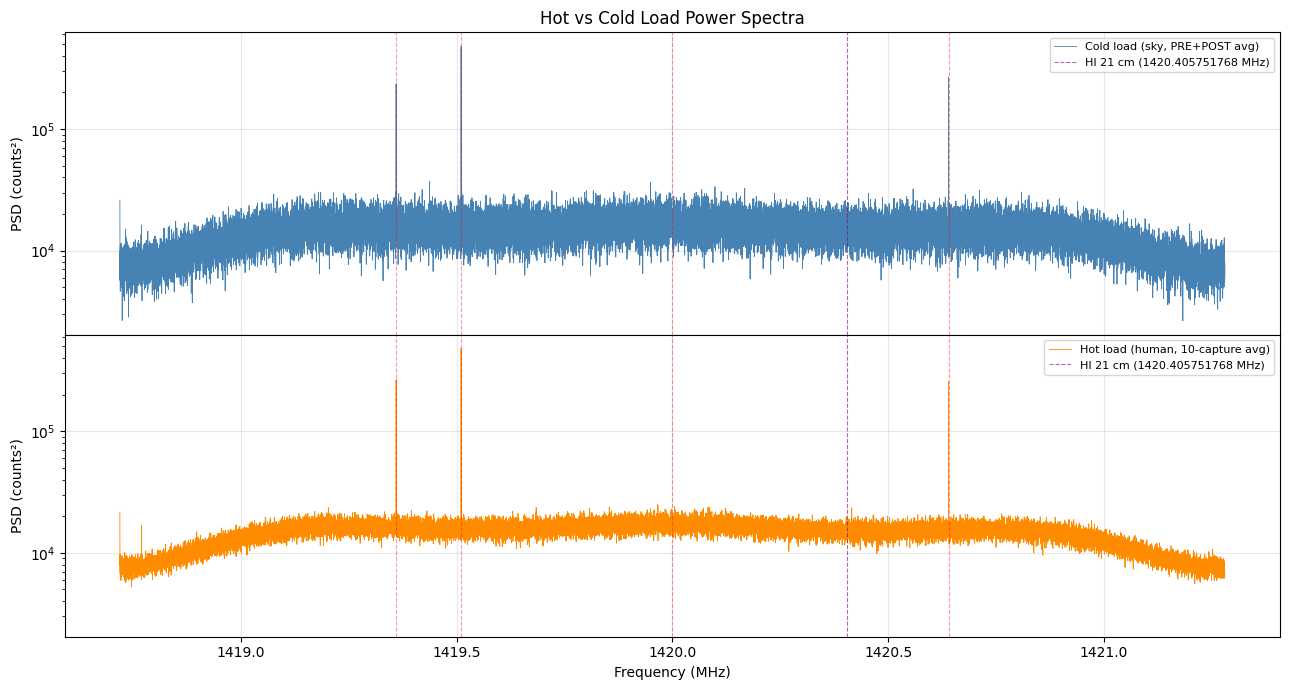

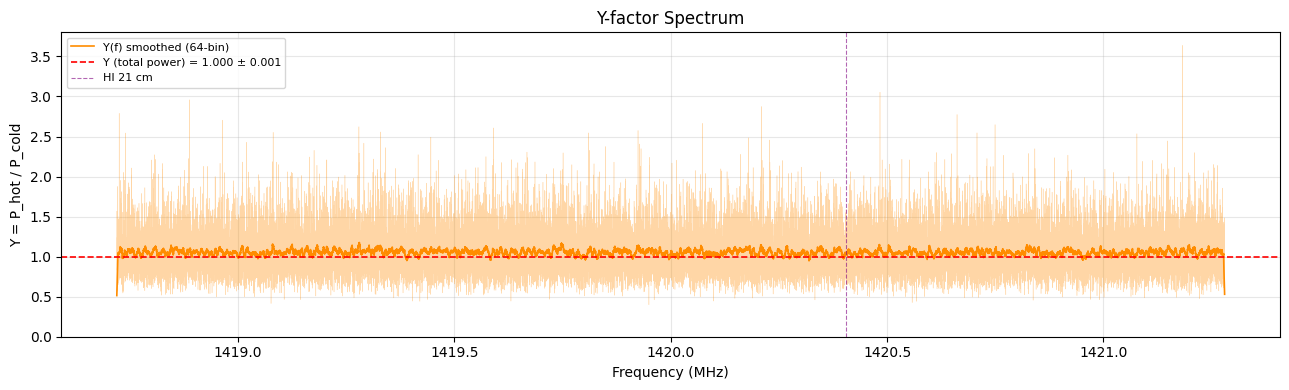

In [6]:
LO_HALF_WIDTH = 10  # bins to blank around the LO/DC peak

# Detect peaks from the individual reference spectra as proxies for the averaged PSDs
cold_peaks = spec_pre.find_peaks()
hot_peaks  = hot_specs[hot_keys[0]].find_peaks()
all_peak_freqs = sorted({round(p['freq_mhz'], 3) for p in cold_peaks + hot_peaks})

# Blank the LO/DC spike at the centre frequency
dc_bin = spec_pre.bin_at(spec_pre.record.center_freq)
lo_mask = np.ones(len(psd_cold), dtype=bool)
lo_mask[max(0, dc_bin - LO_HALF_WIDTH):dc_bin + LO_HALF_WIDTH + 1] = False
psd_cold_plot = np.where(lo_mask, psd_cold, np.nan)
psd_hot_plot  = np.where(lo_mask, psd_hot,  np.nan)

# --- Figure 1: power spectra (cold top, hot bottom) ---
fig, (ax_cold, ax_hot) = plt.subplots(
    2, 1, sharex=True, sharey=True, figsize=(13, 7),
    gridspec_kw={'hspace': 0},
)

ax_cold.semilogy(freqs, psd_cold_plot, lw=0.6, color='steelblue',
                 label='Cold load (sky, PRE+POST avg)')
ax_hot.semilogy(freqs, psd_hot_plot, lw=0.6, color='darkorange',
                label=f'Hot load (human, {len(hot_keys)}-capture avg)')

for ax in (ax_cold, ax_hot):
    ax.axvline(HI_FREQ, color='purple', ls='--', lw=0.8, alpha=0.6,
               label=f'HI 21 cm ({HI_FREQ} MHz)')
    for f in all_peak_freqs:
        ax.axvline(f, color='red', ls='--', lw=0.8, alpha=0.4)
    ax.set_ylabel('PSD (counts²)')
    ax.legend(loc='upper right', fontsize=8)
    ax.grid(True, alpha=0.3)

ax_cold.tick_params(bottom=False)

ax_cold.set_title('Hot vs Cold Load Power Spectra')
ax_hot.set_xlabel('Frequency (MHz)')

fig.tight_layout()
plt.show()

# --- Figure 2: Y-factor spectrum ---
Y_spec   = psd_hot / psd_cold
Y_smooth = np.convolve(Y_spec, np.ones(64) / 64, mode='same')

fig, ax = plt.subplots(figsize=(13, 4))
ax.plot(freqs, Y_spec,   lw=0.3, alpha=0.35, color='darkorange')
ax.plot(freqs, Y_smooth, lw=1.2, color='darkorange', label='Y(f) smoothed (64-bin)')
ax.axhline(Y, color='red', lw=1.2, ls='--', label=f'Y (total power) = {Y:.3f} ± {Y_err:.3f}')
ax.axvline(HI_FREQ, color='purple', ls='--', lw=0.8, alpha=0.6, label='HI 21 cm')
ax.set_xlabel('Frequency (MHz)')
ax.set_ylabel('Y = P_hot / P_cold')
ax.set_title('Y-factor Spectrum')
ax.set_ylim(bottom=0)
ax.legend(fontsize=8)
ax.grid(True, alpha=0.3)
fig.tight_layout()
plt.show()

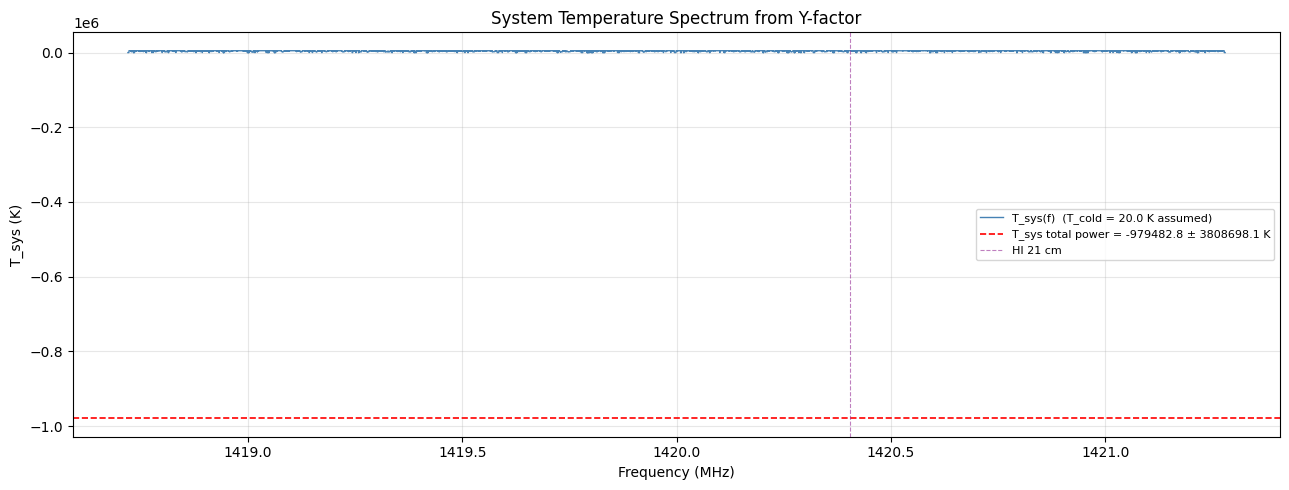

In [7]:
# Per-frequency T_sys from smoothed Y spectrum
T_sys_spec = (T_HOT - Y_smooth * T_COLD) / (Y_smooth - 1)
T_sys_spec = np.clip(T_sys_spec, 0, 5000)  # clip nonphysical extremes

fig, ax = plt.subplots(figsize=(13, 5))
ax.plot(freqs, T_sys_spec, lw=1.0, color='steelblue',
        label=f'T_sys(f)  (T_cold = {T_COLD} K assumed)')
ax.axhline(T_sys, color='red', lw=1.2, ls='--',
           label=f'T_sys total power = {T_sys:.1f} ± {T_sys_err:.1f} K')
ax.axvline(HI_FREQ, color='purple', alpha=0.5, lw=0.8, ls='--', label='HI 21 cm')
ax.set_xlabel('Frequency (MHz)')
ax.set_ylabel('T_sys (K)')
ax.set_title('System Temperature Spectrum from Y-factor')
ax.legend(fontsize=8)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

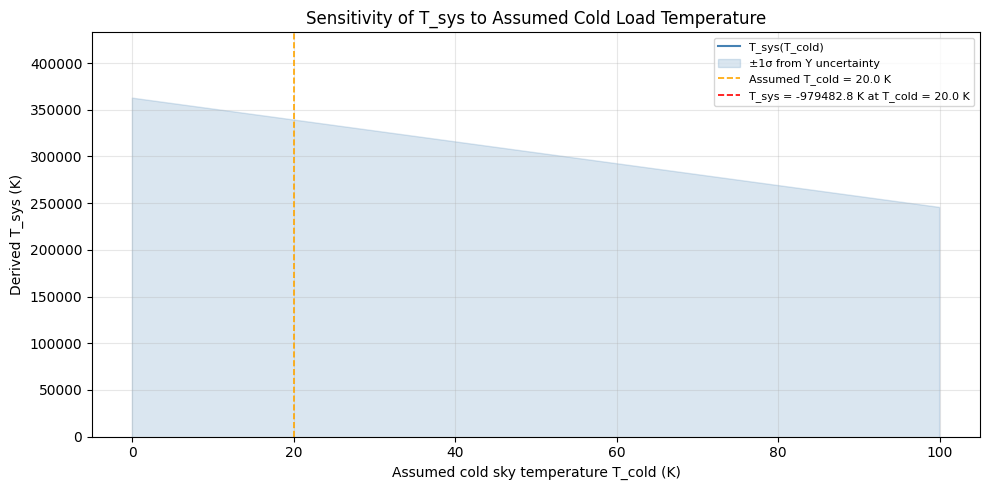

In [8]:
# Sensitivity of T_sys to the assumed T_cold
T_cold_range  = np.linspace(0, 100, 400)
T_sys_range   = (T_HOT - Y * T_cold_range) / (Y - 1)
T_sys_range_hi = (T_HOT - (Y - Y_err) * T_cold_range) / ((Y - Y_err) - 1)
T_sys_range_lo = (T_HOT - (Y + Y_err) * T_cold_range) / ((Y + Y_err) - 1)

fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(T_cold_range, T_sys_range, lw=1.5, color='steelblue', label='T_sys(T_cold)')
ax.fill_between(T_cold_range, T_sys_range_lo, T_sys_range_hi,
                alpha=0.2, color='steelblue', label='±1σ from Y uncertainty')
ax.axvline(T_COLD, color='orange', lw=1.2, ls='--',
           label=f'Assumed T_cold = {T_COLD} K')
ax.axhline(T_sys, color='red', lw=1.2, ls='--',
           label=f'T_sys = {T_sys:.1f} K at T_cold = {T_COLD} K')
ax.set_xlabel('Assumed cold sky temperature T_cold (K)')
ax.set_ylabel('Derived T_sys (K)')
ax.set_title('Sensitivity of T_sys to Assumed Cold Load Temperature')
ax.set_ylim(bottom=0)
ax.legend(fontsize=8)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [9]:
# --- Gain calibration from cold cal signal generator sweep ---
# Derives counts²/W conversion factor so we can express power in physical units.

def _parse_dbm(prefix, stem):
    if not prefix.startswith(stem):
        return None
    try:
        return int(prefix.replace(stem, ''))
    except ValueError:
        return None


tone_dbm   = sorted(d for d in (_parse_dbm(p, 'COLD-TONE-') for p in cold_data) if d is not None)
base_dbm   = sorted(d for d in (_parse_dbm(p, 'COLD-BASE-') for p in cold_data) if d is not None)
paired_dbm = sorted(set(tone_dbm) & set(base_dbm))

cal_rows = []
for dbm in paired_dbm:
    psd_tone = cold_specs[f'COLD-TONE-{dbm}'].psd
    psd_base = cold_specs[f'COLD-BASE-{dbm}'].psd
    cal_rows.append({
        'siggen_amp_dBm': dbm,
        'P_watts': 10 ** (dbm / 10) * 1e-3,
        'total_tone': np.sum(psd_tone),
        'total_base': np.sum(psd_base),
        'total_diff': np.sum(psd_tone) - np.sum(psd_base),
    })
cal_df = pd.DataFrame(cal_rows)

# Noise floor from cold cal baseline captures (obs only — no synth fields set)
cold_base_keys = [k for k in cold_data if not cold_data[k].uses_synth]
noise_total = np.array([cold_specs[k].total_power for k in cold_base_keys])
noise_floor_std = noise_total.std()

# Linear fit in the detectable regime (above 3σ noise floor)
linear_mask = cal_df['total_diff'] > 3 * noise_floor_std
P_lin       = cal_df.loc[linear_mask, 'P_watts'].values
counts2_lin = cal_df.loc[linear_mask, 'total_diff'].values
slope_cal, intercept_cal, r_cal, _, _ = linregress(P_lin, counts2_lin)

print(f'Paired dBm levels: {paired_dbm}')
print(f'Linear region ({linear_mask.sum()} pts): {cal_df.loc[linear_mask, "siggen_amp_dBm"].tolist()} dBm')
print(f'Gain factor:  {slope_cal:.4e} counts²/W')
print(f'R²:           {r_cal**2:.6f}')

Paired dBm levels: [-50, -46, -42, -38, -34, -30]
Linear region (6 pts): [-50, -46, -42, -38, -34, -30] dBm
Gain factor:  8.3126e+14 counts²/W
R²:           0.999940


In [10]:
# Convert ADC counts² to physical power (Watts) and then to temperature
sample_rate = hot_data['HOT-BASE-PRE'].sample_rate

P_cold_W = P_cold_mean / slope_cal
P_hot_W  = P_hot_mean  / slope_cal

# T = P / (k_B * B)
T_cold_measured = P_cold_W / (k_B * sample_rate)
T_hot_measured  = P_hot_W  / (k_B * sample_rate)

# T_sys from cold load power via gain calibration
# At cold load: P_cold = G * k_B * (T_sky + T_sys) * B
# → T_sys = P_cold/(G*k_B*B) - T_sky  = T_cold_measured - T_sky
T_sys_gain = T_cold_measured - T_COLD

print(f'Sample rate / bandwidth: {sample_rate / 1e6:.2f} MHz')
print(f'Gain factor:             {slope_cal:.4e} counts²/W')
print()
print(f'Cold load:  {P_cold_W:.4e} W  →  {T_cold_measured:.1f} K total  →  T_sys = {T_sys_gain:.1f} K  (subtracting T_cold = {T_COLD} K)')
print(f'Hot load:   {P_hot_W:.4e} W  →  {T_hot_measured:.1f} K total  (expect T_hot + T_sys ≈ {T_HOT + T_sys:.1f} K)')
print()
print(f'T_sys (Y-factor method):     {T_sys:.1f} ± {T_sys_err:.1f} K')
print(f'T_sys (gain cal, cold load): {T_sys_gain:.1f} K')

Sample rate / bandwidth: 2.56 MHz
Gain factor:             8.3126e+14 counts²/W

Cold load:  1.7441e-06 W  →  49346189834.7 K total  →  T_sys = 49346189814.7 K  (subtracting T_cold = 20.0 K)
Hot load:   1.7436e-06 W  →  49331579382.2 K total  (expect T_hot + T_sys ≈ -979172.8 K)

T_sys (Y-factor method):     -979482.8 ± 3808698.1 K
T_sys (gain cal, cold load): 49346189814.7 K


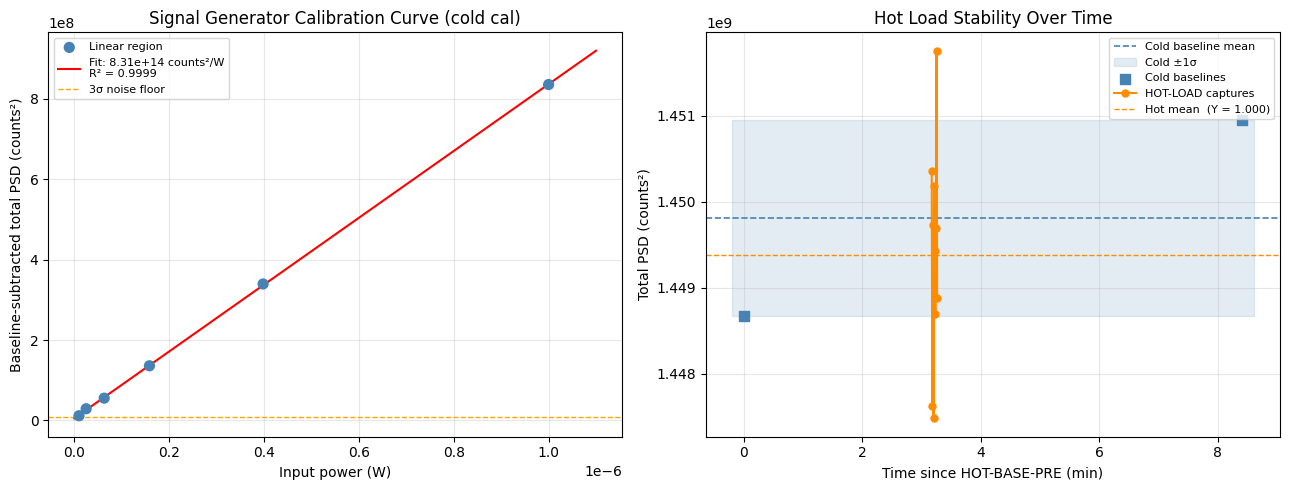

In [11]:
fig, axes = plt.subplots(1, 2, figsize=(13, 5))

# --- Left: signal generator calibration curve ---
ax = axes[0]
colors = ['steelblue' if m else 'gray' for m in linear_mask]
ax.scatter(cal_df['P_watts'], cal_df['total_diff'], c=colors, s=50, zorder=3,
           label='Linear region' if any(linear_mask) else '')
P_range = np.linspace(0, cal_df['P_watts'].max() * 1.1, 200)
ax.plot(P_range, slope_cal * P_range + intercept_cal, 'r-', lw=1.5,
        label=f'Fit: {slope_cal:.2e} counts²/W\nR² = {r_cal**2:.4f}')
ax.axhline(3 * noise_floor_std, color='orange', ls='--', lw=1, label='3σ noise floor')
ax.set_xlabel('Input power (W)')
ax.set_ylabel('Baseline-subtracted total PSD (counts²)')
ax.set_title('Signal Generator Calibration Curve (cold cal)')
ax.legend(fontsize=8)
ax.grid(True, alpha=0.3)

# --- Right: hot load total power over time ---
ax = axes[1]
t0 = hot_data['HOT-BASE-PRE'].unix_time
t_pre  = 0.0
t_post = (hot_data['HOT-BASE-POST'].unix_time - t0) / 60.0
t_hot  = [(hot_data[k].unix_time - t0) / 60.0 for k in hot_keys]
P_hot_each = [hot_specs[k].total_power for k in hot_keys]

ax.axhline(P_cold_mean, color='steelblue', lw=1.2, ls='--', label='Cold baseline mean')
ax.fill_between([t_pre - 0.2, t_post + 0.2],
                P_cold_mean - P_cold_std, P_cold_mean + P_cold_std,
                alpha=0.15, color='steelblue', label='Cold ±1σ')
ax.scatter([t_pre, t_post],
           [hot_specs['HOT-BASE-PRE'].total_power,
            hot_specs['HOT-BASE-POST'].total_power],
           marker='s', s=60, color='steelblue', zorder=4, label='Cold baselines')
ax.plot(t_hot, P_hot_each, 'o-', ms=5, color='darkorange', label='HOT-LOAD captures')
ax.axhline(P_hot_mean, color='darkorange', lw=1.0, ls='--',
           label=f'Hot mean  (Y = {Y:.3f})')
ax.set_xlabel('Time since HOT-BASE-PRE (min)')
ax.set_ylabel('Total PSD (counts²)')
ax.set_title('Hot Load Stability Over Time')
ax.legend(fontsize=8)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [12]:
print('=' * 56)
print('HOT CALIBRATION SUMMARY')
print('=' * 56)
print(f'  T_hot  (human body, assumed):      {T_HOT:.1f} K')
print(f'  T_cold (sky at horizontal, assumed): {T_COLD:.1f} K')
print()
print(f'  Y-factor (total power):            {Y:.4f} ± {Y_err:.4f}')
print()
print(f'  T_sys  [Y-factor method]:          {T_sys:.1f} ± {T_sys_err:.1f} K')
print(f'  T_sys  [gain cal, cold load]:      {T_sys_gain:.1f} K')
print()
print(f'  Gain factor (from cold cal):       {slope_cal:.4e} counts²/W')
print(f'  Bandwidth:                         {sample_rate / 1e6:.2f} MHz')
print()
print(f'  Measured cold load temperature:    {T_cold_measured:.1f} K  (= T_sky + T_sys)')
print(f'  Measured hot  load temperature:    {T_hot_measured:.1f} K  (expect ≈ {T_HOT + T_sys:.0f} K)')
print()
print(f'Note: T_sys is sensitive to T_cold — see sensitivity plot.')
print('=' * 56)

HOT CALIBRATION SUMMARY
  T_hot  (human body, assumed):      310.0 K
  T_cold (sky at horizontal, assumed): 20.0 K

  Y-factor (total power):            0.9997 ± 0.0012

  T_sys  [Y-factor method]:          -979482.8 ± 3808698.1 K
  T_sys  [gain cal, cold load]:      49346189814.7 K

  Gain factor (from cold cal):       8.3126e+14 counts²/W
  Bandwidth:                         2.56 MHz

  Measured cold load temperature:    49346189834.7 K  (= T_sky + T_sys)
  Measured hot  load temperature:    49331579382.2 K  (expect ≈ -979173 K)

Note: T_sys is sensitive to T_cold — see sensitivity plot.
